In [1]:
# Importing the necessary libraries and packages for the fraud model

import warnings
warnings.filterwarnings("ignore")

# !pip install xgboost
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import metrics 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC
import xgboost as xgb

import collections
from collections import Counter

from xgboost import XGBClassifier
import xgboost as xgb


sns.set()

In [2]:
chunksize = 10 ** 5  # adjust this value depending on your available memory
chunks = []
for chunk in pd.read_csv('new_engineered_features.csv', chunksize=chunksize):
    chunks.append(chunk)

df = pd.concat(chunks, axis=0)
del chunks

In [3]:
# Looking at the top 15 data entries
df.head(15)

,cc_num,merchant,amt,gender,street,state,city_pop,job,merch_lat,merch_long,...,risk_hours_High Risk,risk_hours_Low Risk,risk_hours_Medium Risk,risk_level_High Risk Category,risk_level_Low Risk Category,risk_level_Medium Risk Category,avg_amt_24hr,agg_High_risk_cols,agg_medium_risk_cols,agg_low_risk_cols
0,2703186189652095,514,4.97,0,568,27,3495,42,-0.494354,0.593864,...,0,0,1,1,0,0,34.400000,0.0,0.000,0.0
1,630423337322,241,107.23,0,435,47,149,60,2.078699,-2.030341,...,0,0,1,1,0,0,68.220000,0.0,0.000,0.0
2,38859492057661,390,220.11,1,602,13,4154,38,0.902849,-1.592323,...,0,0,1,0,0,1,445.778000,0.0,0.000,0.0
3,3534093764340240,360,45.00,1,930,26,1939,42,1.662886,-1.621848,...,0,0,1,0,0,1,39.700000,0.0,39.700,0.0
4,375534208663984,297,41.96,1,418,45,99,42,0.026941,0.841909,...,0,0,1,0,0,1,43.655000,0.0,43.655,0.0
5,4767265376804500,607,94.63,0,471,38,2158,46,0.414116,1.021982,...,0,0,1,0,0,1,31.435000,0.0,0.000,0.0
6,30074693890476,534,44.54,0,882,16,2691,42,-0.269020,-0.720851,...,0,0,1,0,1,0,131.041667,0.0,0.000,0.0
7,6011360759745864,107,71.65,1,224,45,6018,42,0.080385,0.848602,...,0,0,1,0,0,1,39.722857,0.0,0.000,0.0
8,4922710831011201,250,4.27,0,685,38,1472,12,0.355098,0.745643,...,0,0,1,0,0,1,88.624000,0.0,88.624,0.0
9,2720830304681674,563,198.39,0,213,42,151785,42,-0.265792,0.199046,...,0,0,1,1,0,0,56.280000,0.0,0.000,0.0


In [4]:
# Scaling the features in the original dataset

scaler = StandardScaler()

df['scaled_amt'] = scaler.fit_transform(df['amt'].values.reshape(-1,1))
df['scaled_avg_amt_24hr'] = scaler.fit_transform(df['avg_amt_24hr'].values.reshape(-1,1))
df['scaled_agg_High_risk_cols'] = scaler.fit_transform(df['agg_High_risk_cols'].values.reshape(-1,1))
df['scaled_agg_medium_risk_cols'] = scaler.fit_transform(df['agg_medium_risk_cols'].values.reshape(-1,1))
df['scaled_agg_low_risk_cols'] = scaler.fit_transform(df['agg_low_risk_cols'].values.reshape(-1,1))
df['scaled_city_pop']= scaler.fit_transform(df['city_pop'].values.reshape(-1,1))

# Dropping the original unscaled features 
df.drop(['amt','avg_amt_24hr','agg_High_risk_cols','agg_medium_risk_cols', 'agg_low_risk_cols', 'city_pop'], axis=1 , inplace=True)

df.head()

,cc_num,merchant,gender,street,state,job,merch_lat,merch_long,is_fraud,year,...,risk_hours_Medium Risk,risk_level_High Risk Category,risk_level_Low Risk Category,risk_level_Medium Risk Category,scaled_amt,scaled_avg_amt_24hr,scaled_agg_High_risk_cols,scaled_agg_medium_risk_cols,scaled_agg_low_risk_cols,scaled_city_pop
0,2703186189652095,514,0,568,27,42,-0.494354,0.593864,0,0,...,1,1,0,0,-0.407826,-0.373768,-0.038012,-0.092734,-0.143114,-0.282589
1,630423337322,241,0,435,47,60,2.078699,-2.030341,0,0,...,1,1,0,0,0.230039,-0.022738,-0.038012,-0.092734,-0.143114,-0.293670
2,38859492057661,390,1,602,13,38,0.902849,-1.592323,0,0,...,1,0,0,1,0.934149,3.896078,-0.038012,-0.092734,-0.143114,-0.280406
3,3534093764340240,360,1,930,26,42,1.662886,-1.621848,0,0,...,1,0,0,1,-0.158132,-0.318757,-0.038012,1.779568,-0.143114,-0.287742
4,375534208663984,297,1,418,45,42,0.026941,0.841909,0,0,...,1,0,0,1,-0.177094,-0.277707,-0.038012,1.966090,-0.143114,-0.293835


# Model Building Pipeline

For the Model Building and Machine learning process, we will use both oversampling and undersampling techniques to find the best model suitable for this problem. We will experiment with Near Miss-3 Algorithm for undersampling the Majority class as well as SMOTE for Oversampling the Minority Class.

In [5]:
# Declaring the Dependent and Independent variables

X = df.drop('is_fraud', axis=1)  # Features to drop
y = df['is_fraud']  # Target variable

# Define NearMiss-3
nm3 = NearMiss(version=3)

# Undersampling the original dataframe using NearMiss-3

X_nm, y_nm = nm3.fit_resample(X, y)

### Undersampled DataFrame

In [6]:
# Ensuring that 'y_nm' is a numpy array
y_nm = np.array(y_nm)

# Create a new DataFrame 'df_nm' by horizontally stacking 'X_nm' and 'y_nm'
df_nm = pd.DataFrame(np.hstack((X_nm, y_nm[:, None])), columns=df.columns)

# Convert the 'is_Fraud' column of 'df_nm' to integer type
df_nm.is_fraud = df_nm.is_fraud.astype(int)

# Display the first few rows of 'df_nm'
df_nm.head()

,cc_num,merchant,gender,street,state,job,merch_lat,merch_long,is_fraud,year,...,risk_hours_Medium Risk,risk_level_High Risk Category,risk_level_Low Risk Category,risk_level_Medium Risk Category,scaled_amt,scaled_avg_amt_24hr,scaled_agg_High_risk_cols,scaled_agg_medium_risk_cols,scaled_agg_low_risk_cols,scaled_city_pop
0,4.244954e+18,574.0,1.0,809.0,31.0,42.0,0.083340,1.137331,0,1.0,...,0.0,0.0,1.0,0.019767,5.643933,-0.038012,-0.092734,-0.143114,-0.291431,0.0
1,4.244954e+18,603.0,1.0,809.0,31.0,42.0,0.046156,1.111843,0,1.0,...,0.0,0.0,1.0,0.073723,0.032273,-0.038012,-0.092734,-0.143114,-0.291431,0.0
2,4.244954e+18,555.0,1.0,809.0,31.0,42.0,0.317804,1.068762,0,1.0,...,1.0,0.0,0.0,0.047026,0.122055,-0.038012,-0.092734,-0.143114,-0.291431,0.0
3,4.089096e+18,522.0,0.0,683.0,43.0,50.0,-1.270642,-0.329328,0,1.0,...,0.0,0.0,1.0,-0.087396,-0.394665,-0.038012,-0.092734,-0.143114,-0.212906,0.0
4,4.089096e+18,410.0,0.0,683.0,43.0,50.0,-1.142086,-0.357738,0,1.0,...,0.0,1.0,0.0,-0.027078,-0.146045,-0.038012,-0.092734,2.490312,-0.212906,0.0


### Note: 

In building Fraud Detection models and training them under various machine learning models, recall tends to be more important of a metric than precision as it is more costly for banking systems and institutions to miss a fraudulent transaction than if they classified a non-fraudulent transaction as fraudulent. 

At the same time, we must consider the resources these banking systems currently have at their disposal in investigating non fraudulent transactions that was classified as fraudulent. In this case, we will aim for a model that can achieve high recall (catch most or all the fraudulent transactions) but also have a moderate to above average amount of precision (label as much legitimate transactions as legitimate). 

Our original training data has alot more legitimate transactions than fraudulent transactions so optimizing the precision score is a consideration that we have to make so that it is not costly for banks to implement this machine learning model/

We will use both Near Miss-3 Undersampling to find the right technique that will give us the result we intend. 

### Train / Test Split 

In [7]:
X = df_nm.drop('is_fraud', axis=1)  # Features to drop from the undersampled DataFrame
y = df_nm['is_fraud']  # Target variable for prediction

In [8]:
# Splitting the Undersampled DataFrame into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [9]:
# Creating a dictionary for the classification algorithms

models = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Classifier': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest Classifier': RandomForestClassifier(),
    'XgBoost': xgb.XGBClassifier()
}

### Cross Validation Across Classifiers

In [10]:
from sklearn.model_selection import cross_val_score

# Calculate the cross-validation score for each classifier
print('Cross-Validation Scores:-')

for key, model in models.items():
    model.fit(X_train, y_train)
    cv_score = cross_val_score(model, X_train, y_train, cv=5)
    
    print('{}: {}'.format(key,round(cv_score.mean()*100.0, 2)))

Cross-Validation Scores:-
Logistic Regression: 76.12
Support Vector Classifier: 76.12
Decision Tree: 98.99
Random Forest Classifier: 98.29
XgBoost: 99.94


Based on these values, we can see that the Classifiers: XgBoost, Random Forest and Decision Tree have the Highest Scores.
These scores shows how these models will generalize to an independent (unseen) data.

It is also important to note that the technique used in conducting Cross Validation above is not an optimal way. If a dataframe is resampled, then this can introduce data leakage into models which may lead to overfitting. This prevents the model from learning or generalizing to real world data. 

Techniques such as Cross Validation must be done in such a way where the Original dataframe is split into folds that maintain the same distribution of the original data and then cross validation and resampling (if possible) must be applied subsequently. We will do it properly now in the subsequent code blocks.

# Cross Validation | Undersampling vs. Oversampling Techniques

In [11]:
from sklearn.model_selection import StratifiedKFold

original_X = df.drop('is_fraud',axis=1)
original_y = df['is_fraud']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(original_X, original_y):
    print("Train: {} Test: {}".format(train_index, test_index))
    original_Xtrain, original_Xtest = original_X.iloc[train_index], original_X.iloc[test_index]
    original_ytrain, original_ytest = original_y.iloc[train_index], original_y.iloc[test_index]
    
#Turn into arrays    
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

#Check if the labels are equally distibuted among the train and test set.
train_unique_label, train_count_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_count_label = np.unique(original_ytest, return_counts=True)

print('\n Label Distribution:')
print('Train: {}'.format(train_count_label/len(original_ytrain)))
print('Test: {}'.format(test_count_label/len(original_ytest)))

Train: [ 170125  170149  170246 ... 1296672 1296673 1296674] Test: [     0      1      2 ... 259804 259805 259806]
Train: [      0       1       2 ... 1296672 1296673 1296674] Test: [170125 170149 170246 ... 518765 518766 518767]
Train: [      0       1       2 ... 1296672 1296673 1296674] Test: [491486 491497 491561 ... 778084 778085 778086]
Train: [      0       1       2 ... 1296672 1296673 1296674] Test: [ 768088  768147  768152 ... 1047089 1047157 1047208]
Train: [      0       1       2 ... 1047089 1047157 1047208] Test: [1037304 1037305 1037306 ... 1296672 1296673 1296674]

 Label Distribution:
Train: [0.99421212 0.00578788]
Test: [0.99420826 0.00579174]


## Appropriate Near Miss Resampling

In [12]:
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

# Initialize a dictionary to store the metrics for each model
metrics_dict = {name: {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []} for name in models.keys()}

# Define NearMiss-3
nm3 = NearMiss(version=3)

# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Classifier': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest Classifier': RandomForestClassifier(),
    'XgBoost': xgb.XGBClassifier()
}

In [13]:
for train, test in sss.split(original_Xtrain, original_ytrain):
    X_train, X_test = original_Xtrain[train], original_Xtrain[test]
    y_train, y_test = original_ytrain[train], original_ytrain[test]

    for name, model in models.items():
        # Define the pipeline with NearMiss undersampling and current model
        pipeline = imbalanced_make_pipeline(NearMiss(version=3), model)
        
        # Fit the pipeline
        undersample_model = pipeline.fit(X_train, y_train)
        
        # Predict
        prediction = undersample_model.predict(X_test)
        
        # Store the metrics in the dictionary
        metrics_dict[name]['accuracy'].append(accuracy_score(y_test, prediction))
        metrics_dict[name]['precision'].append(precision_score(y_test, prediction))
        metrics_dict[name]['recall'].append(recall_score(y_test, prediction))
        metrics_dict[name]['f1'].append(f1_score(y_test, prediction))
        metrics_dict[name]['auc'].append(roc_auc_score(y_test, prediction))

# Print the average metrics for each model
for name, metrics in metrics_dict.items():
    print('Average metrics for', name)
    print('Average accuracy: {:.4f}'.format(np.mean(metrics['accuracy'])))
    print('Average precision: {:.4f}'.format(np.mean(metrics['precision'])))
    print('Average recall: {:.4f}'.format(np.mean(metrics['recall'])))
    print('Average F1-score: {:.4f}'.format(np.mean(metrics['f1'])))
    print('Average ROC AUC score: {:.4f}'.format(np.mean(metrics['auc'])))
    print()

Average metrics for Logistic Regression
Average accuracy: 0.0058
Average precision: 0.0058
Average recall: 1.0000
Average F1-score: 0.0115
Average ROC AUC score: 0.5000

Average metrics for Support Vector Classifier
Average accuracy: 0.0058
Average precision: 0.0058
Average recall: 1.0000
Average F1-score: 0.0115
Average ROC AUC score: 0.5000

Average metrics for Decision Tree
Average accuracy: 0.0878
Average precision: 0.0063
Average recall: 0.9927
Average F1-score: 0.0126
Average ROC AUC score: 0.5376

Average metrics for Random Forest Classifier
Average accuracy: 0.2235
Average precision: 0.0107
Average recall: 0.9958
Average F1-score: 0.0211
Average ROC AUC score: 0.6074

Average metrics for XgBoost
Average accuracy: 0.0901
Average precision: 0.0064
Average recall: 0.9960
Average F1-score: 0.0127
Average ROC AUC score: 0.5404



### Summary metrics across folds | Undersampling Techniques

Based on these metrics, we can see that the stronger models {Random Forest, XgBoost, & Decision Tree} is not able to differentiate between the classes in the dataset. We see higher scores for Recall on the fraud class on the stronger models but at the same time, the recall scores for the non-fraud class is alarmingly small. Additionally, the precision scores for the stronger models are alarmigly small. This is a cause of concern. The verdict of this is that the Near Miss undersampling or other undersampling techniques is not effective in balancing this data so that the model can learn the patterns well.

The reasons for this underperformance could range from:

1. Loss of Information: NearMiss undersampling reduces the number of instances from the majority class (non-fraudulent transactions), which can lead to loss of information. Some of the non-fraudulent transactions that are removed might contain valuable information that helps distinguish them from fraudulent transactions.
   2. 
Misrepresentation of Majority Class: By only keeping the non-fraudulent transactions that are closest to the fraudulent transactions, NearMiss might result in a misrepresentation of the majority class. The model might perform well on the undersampled training data but fail to generalize to new data

3. 
Complexity of Fraudulent Behavior: Fraudulent transactions can be complex and difficult to predict. They might not necessarily be close to non-fraudulent transactions in the feature space, which is what NearMissneedso
.

## SMOTE Oversampling using XgBoost

Decision Rationale: The Decision to use XgBoost as the model of focus for SMOTE Oversampling with Cross Validation is due to the following reason: 

The size of the oversampled SMOTE dataset - which is now in the 2 Million range, deserves a model that has a significant boosting capability in identifying complex patterns and relationships in the data. At the same time, we wanted the model to provide some considerable level of interpretability, wherein the model can show how it arrived at its decisions. 

Therefore, this model training will discourage the use of black box models like Neural Networks, (NNs) as they do not provide much level of interpretability in understanding fraudulent behaviour and tendencies when compared to using gradient boosting models like XgBoost. 

A simplier model that balances interprebility with computational cost will be the better model for this use case.

In [14]:
from imblearn.over_sampling import SMOTE

# Initialize a dictionary to store the metrics for each model
metrics_dict = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}

# Define hyperparameters for RandomizedSearchCV
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'n_estimators': [100, 200, 300, 400, 500]
}

# Classifier with optimal parameters
xgb_sm = XGBClassifier(random_state=42)

rand_xgb = RandomizedSearchCV(xgb_sm, xgb_params, n_iter=4, random_state=42)

rand_xgb.fit(original_Xtrain, original_ytrain)
best_est = rand_xgb.best_estimator_

In [15]:
for train, test in sss.split(original_Xtrain, original_ytrain):
    # Use best estimator in your pipeline
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), best_est)
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    prediction = model.predict(original_Xtrain[test])
    
    metrics_dict['accuracy'].append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    metrics_dict['precision'].append(precision_score(original_ytrain[test], prediction))
    metrics_dict['recall'].append(recall_score(original_ytrain[test], prediction))
    metrics_dict['f1'].append(f1_score(original_ytrain[test], prediction))
    metrics_dict['auc'].append(roc_auc_score(original_ytrain[test], prediction))

    # Generate classification report
    print(classification_report(original_ytrain[test], prediction))
    
# After fitting rand_xgb
print("Best hyperparameters:")
print(rand_xgb.best_params_)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    206268
           1       0.55      0.89      0.68      1200

    accuracy                           1.00    207468
   macro avg       0.77      0.94      0.84    207468
weighted avg       1.00      1.00      1.00    207468

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    206267
           1       0.62      0.86      0.72      1201

    accuracy                           1.00    207468
   macro avg       0.81      0.93      0.86    207468
weighted avg       1.00      1.00      1.00    207468

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    206267
           1       0.67      0.86      0.75      1201

    accuracy                           1.00    207468
   macro avg       0.83      0.93      0.88    207468
weighted avg       1.00      1.00      1.00    207468

              preci

In [16]:
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(metrics_dict['accuracy'])))
print("precision: {}".format(np.mean(metrics_dict['precision'])))
print("recall: {}".format(np.mean(metrics_dict['recall'])))
print("f1: {}".format(np.mean(metrics_dict['f1'])))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9962924402799468
precision: 0.6329813402077414
recall: 0.8769178462392452
f1: 0.7339674115188264
---------------------------------------------------------------------------------------------------------------------------------------


### Confusion Matrix for XgBoost Classifier

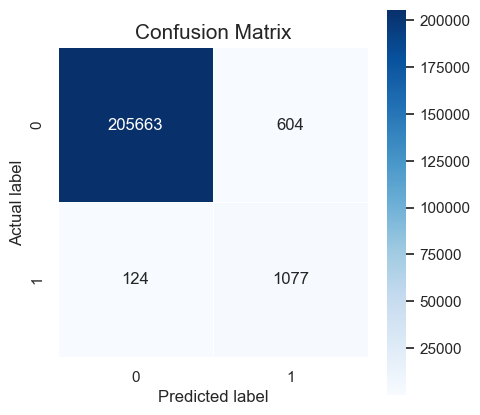

In [17]:
cm = confusion_matrix(original_ytrain[test], prediction)

# Assuming 'cm' is your confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix', size = 15)
plt.show()

Findings:
The model is quite good at identifying non-fraud cases (high TN).Also, the number of fraud cases that the model misses (FN) is relatively low.
The model does make some mistakes by classifying non-fraud cases as fraud (FP), but this number is relativelysmall  but overall, the model is is reasonably good at catching fraud case..

### Receiver Operating Characteristic Curve 

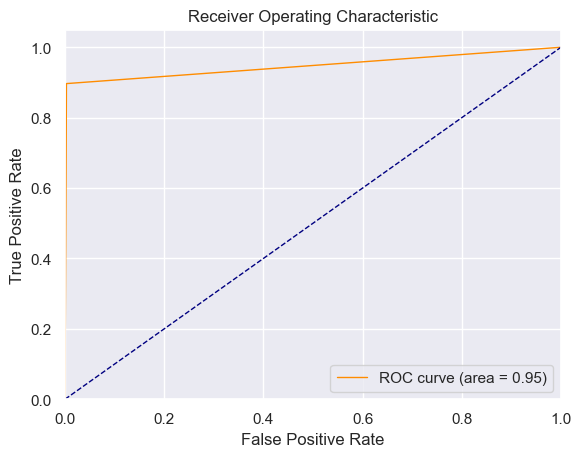

In [18]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(original_ytrain[test], prediction)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The model has a ROC Curve area of 0.95 which indicates that the model has a high true positive rate (it correctly identifies positives) and a low false positive rate (it doesn’t incorrectly identify negatives as positives).

### Influencial Features 

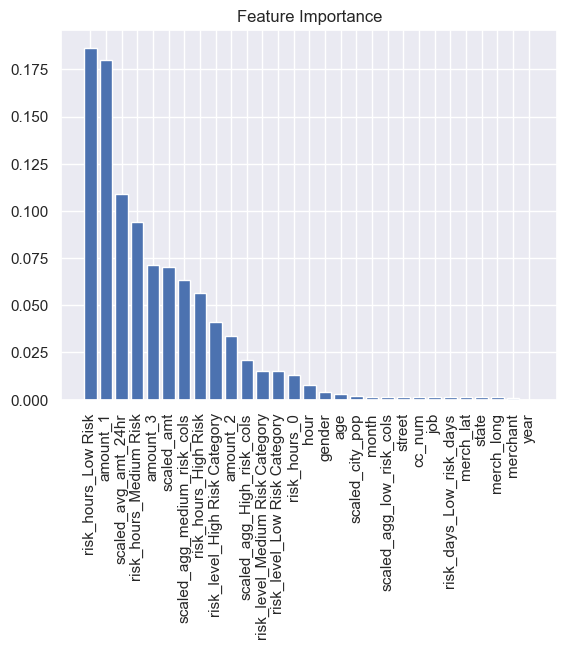

In [19]:
# Assuming that 'model' is your trained XGBoost model
# and 'feature_names' is a list of your feature names

# Assuming 'df' is your training dataframe
feature_names = df.drop('is_fraud', axis=1).columns.tolist()

# Get feature importances
importances = model.named_steps['xgbclassifier'].feature_importances_

# Sort feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [feature_names[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(len(names)), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(len(names)), names, rotation=90)

# Show plot
plt.show()

The feature importance shows that features such as Low Risk Hours, the frequent range of dollar amounts normally being spent on fraud ,as well as the average amount spent on transactions per 24 hours were the most influencial features in detecting fraudulent behaviour in the dataset. 

Lesser influencial  features such as the hours when medium risk for fraudulent transactions, as well as the hours when there is a high risk of fraudulent transactions and also, the Categories for High Risk Fraudulent transactions also showed some considerable influences in the model's decisions. 

### Threshold Adjustment on XgBoost Classifier:

In cases of credit card fraud detection, the cost of misclassifing a fraudulent transaction as legitimate is high. Therefore, there will always be a priorization of recall over precison in these use cases. However, there is a caveat! There is a trade off decision that must be made as lower thresholds might maximize recall at the expense of precision. 

We will experiment lowering the threshold to maximize on recall in this case by dropping the model's decision threshold from 0.5 to 0.2. This is to maximize on the recall metric. 

In [23]:
# Use best estimator in your pipeline
pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), best_est)

for train, test in sss.split(original_Xtrain, original_ytrain):
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    
    # Get predicted probabilities
    prediction_probs = model.predict_proba(original_Xtrain[test])[:, 1]
    
    # Make predictions based on the newly defined threshold
    prediction = (prediction_probs > 0.42).astype(int)
    
    # Compute metrics
    metrics_dict['accuracy'].append(accuracy_score(original_ytrain[test], prediction))
    metrics_dict['precision'].append(precision_score(original_ytrain[test], prediction))
    metrics_dict['recall'].append(recall_score(original_ytrain[test], prediction))
    metrics_dict['f1'].append(f1_score(original_ytrain[test], prediction))
    metrics_dict['auc'].append(roc_auc_score(original_ytrain[test], prediction))

    # Generate classification report
    print(classification_report(original_ytrain[test], prediction))

# After fitting rand_xgb
print("Best hyperparameters:")
print(rand_xgb.best_params_)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    206268
           1       0.46      0.91      0.61      1200

    accuracy                           0.99    207468
   macro avg       0.73      0.95      0.80    207468
weighted avg       1.00      0.99      0.99    207468

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    206267
           1       0.54      0.89      0.67      1201

    accuracy                           0.99    207468
   macro avg       0.77      0.94      0.83    207468
weighted avg       1.00      0.99      1.00    207468

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    206267
           1       0.60      0.89      0.72      1201

    accuracy                           1.00    207468
   macro avg       0.80      0.94      0.86    207468
weighted avg       1.00      1.00      1.00    207468

              preci

In [24]:
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(metrics_dict['accuracy'])))
print("precision: {}".format(np.mean(metrics_dict['precision'])))
print("recall: {}".format(np.mean(metrics_dict['recall'])))
print("f1: {}".format(np.mean(metrics_dict['f1'])))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.995688331051857
precision: 0.591130802703691
recall: 0.8900199833472107
f1: 0.7080710214419315
---------------------------------------------------------------------------------------------------------------------------------------


Based on these metrics generated on StratifiedKFold Cross Validation, we see that for each of the 5 Folds, the Recall values on the Non Fraud and Fraud cases are higher due to the lowering of the decision threshold. This shows that the model is catching nearly all fraudulent and non fraudulent transactions but this comes with the added expense of more Transactional False Alarms to customers (Lower precision scores across the 5 validation folds than when the model was trained on the default threshold of 0.5). 

The Average Recall scores increased to 89% , which means that the model is able to catch 89% of all fraud cases in the dataset. This is an improvement from 86.7% when the classifier's decision threshold was at 0.5. However, on average, the precision scores decreased from 63% to 59%, which indicates that this model is 59% precise in predicting fraud cases. This is due to the trade off rule between recall and precision in imbalanced datasets. 

As stated before, a higher recall score is more desirable in fraud detection systems.

### Confusion Matrix for Adjusted XgBoost Model

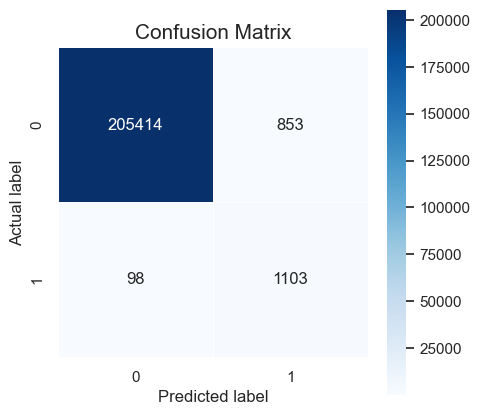

In [25]:
cm = confusion_matrix(original_ytrain[test], prediction)
# Assuming 'cm' is your confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix', size = 15)
plt.show()

Utilizing a model like this in production will entirely depend on the financial institution's cost associated with different types of errors. For eg. If they discover that the cost of one fraudulent transaction is more costly than what they might be currently earning in total, then utilizing a model like this might be significantly helpful.

Ideally, Financial institutions would like to see models that capture most if not all fraud and non fraud cases even if it comes at the expense of more False Alarms to customers. 

We also see that the model is able to correctly identify 205,414 transactions in the positive class. Overall, This confusion matrix shows a slight improvement when compared to the previous model at the threshold of 0.5. 

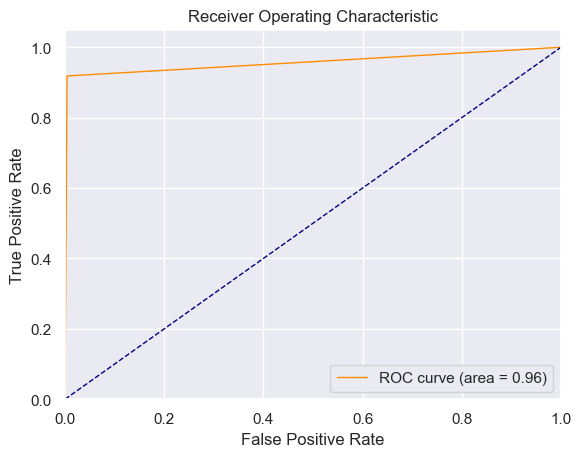

In [26]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(original_ytrain[test], prediction)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The Area under the ROC Curve has increased from 0.95 to 0.96, signifying that the classifier is better at ranking a randomly chosen positive instance higher than a randomly chosen negative instance. The model is better at distinguishing between the positive and negative classes.

## Model Consideration 

We will consider the XGBoost Classifier trained on SMOTE Oversampling with Decision Threshold of 0.42 and hyparameters {'subsample': 0.7, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.5} to be the model for predicting fraud. This 
is chosenbecause  on its performance on primarily the Recall metrics and precision scores.
Tthis model tends to balance interprebility with computational efficiency and so it will be the better model.

Moreover, due to the fact that the number of fraud cases are really small during the dataset and that they aren't correlated with large amounts spent, we can infer that the financial institutions aren't losing much value from fraudulent transactions. Quite simply, if we are aiming for a model that balances precision and recall at the specified threshold of 0.25, thsi will stengthen financial institution's capabilities in detecting fraudulent transactions when they do occur. 